In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, coint, acovf, ccovf

In [2]:
parcel = 1

In [3]:
# Import dataset
df = pd.read_csv('data/agroclimatology_parcel_{}.csv'.format(parcel), delimiter=',', usecols=['fecha', 'eto', 'viento_med', 'precip', 'temp_med', "hr_med", "rad_med"])
df.head()

# Convert fecha column to datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Make fecha as index
df = df.set_index('fecha')

In [4]:
# Info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 606 entries, 2022-01-10 to 2023-08-23
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eto         606 non-null    float64
 1   viento_med  606 non-null    float64
 2   precip      606 non-null    float64
 3   temp_med    606 non-null    float64
 4   hr_med      606 non-null    float64
 5   rad_med     606 non-null    float64
dtypes: float64(6)
memory usage: 33.1 KB


In [5]:
# Check for outliers
df.describe()

,eto,viento_med,precip,temp_med,hr_med,rad_med
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,3.420710,0.691617,0.874257,19.754934,55.378168,216.677261
std,1.954741,0.351685,4.322017,7.155232,13.865723,97.345293
min,0.460000,0.000000,0.000000,5.700000,20.620000,18.920000
25%,1.457500,0.470000,0.000000,13.545000,45.315000,129.637500
50%,3.525000,0.680000,0.000000,19.595000,54.880000,231.240000
75%,5.317500,0.860000,0.000000,26.630000,65.615000,305.445000
max,6.630000,2.940000,57.400000,33.580000,89.080000,369.440000


In [6]:
# Check for missing values
df.isna().sum()

eto           0
viento_med    0
precip        0
temp_med      0
hr_med        0
rad_med       0
dtype: int64

In [7]:
# Check for duplicated values
df.duplicated().sum()

19

<Axes: >

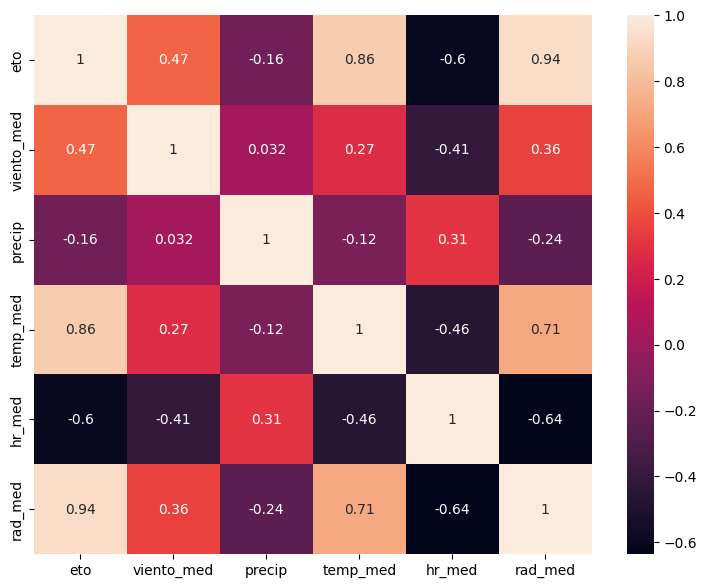

In [8]:
# Plot the correlation matrix
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(), annot=True)

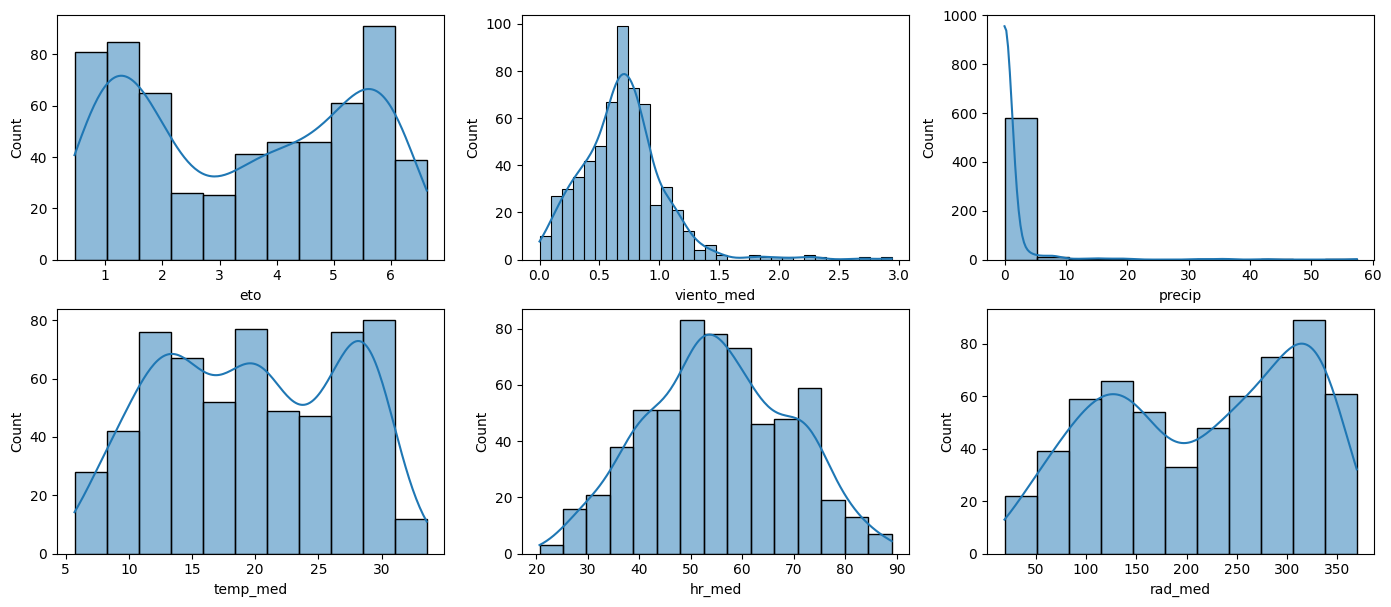

In [9]:
# Plot the distribution of the target variable
plt.figure(figsize=(17, 7))
# distribution plot for every column
for i, col in enumerate(df.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)

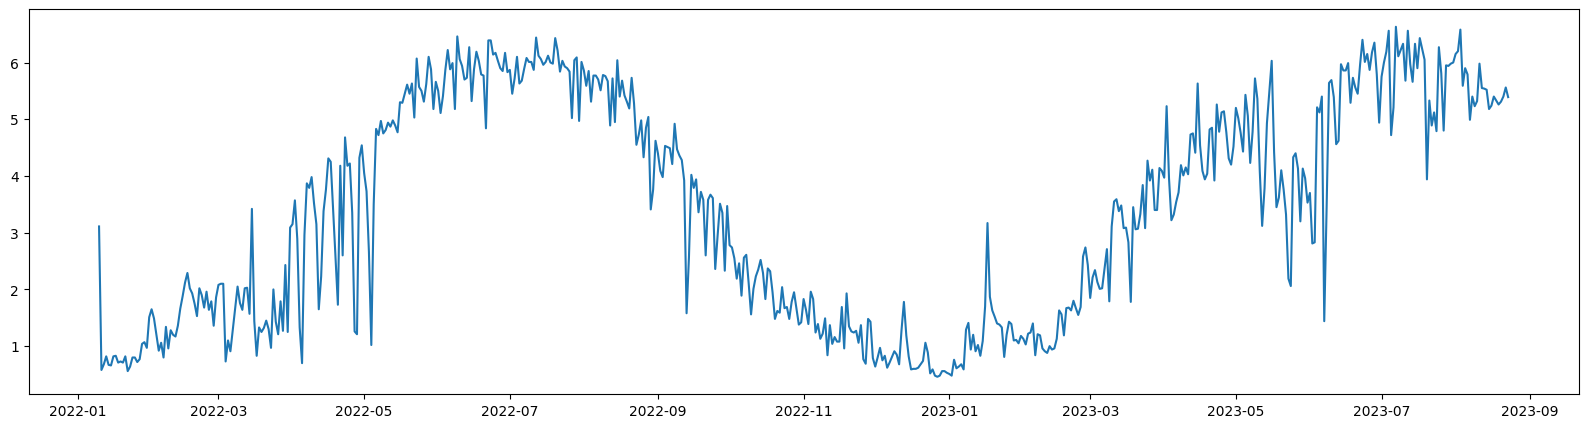

In [10]:
# Plot the target variable
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['eto'])


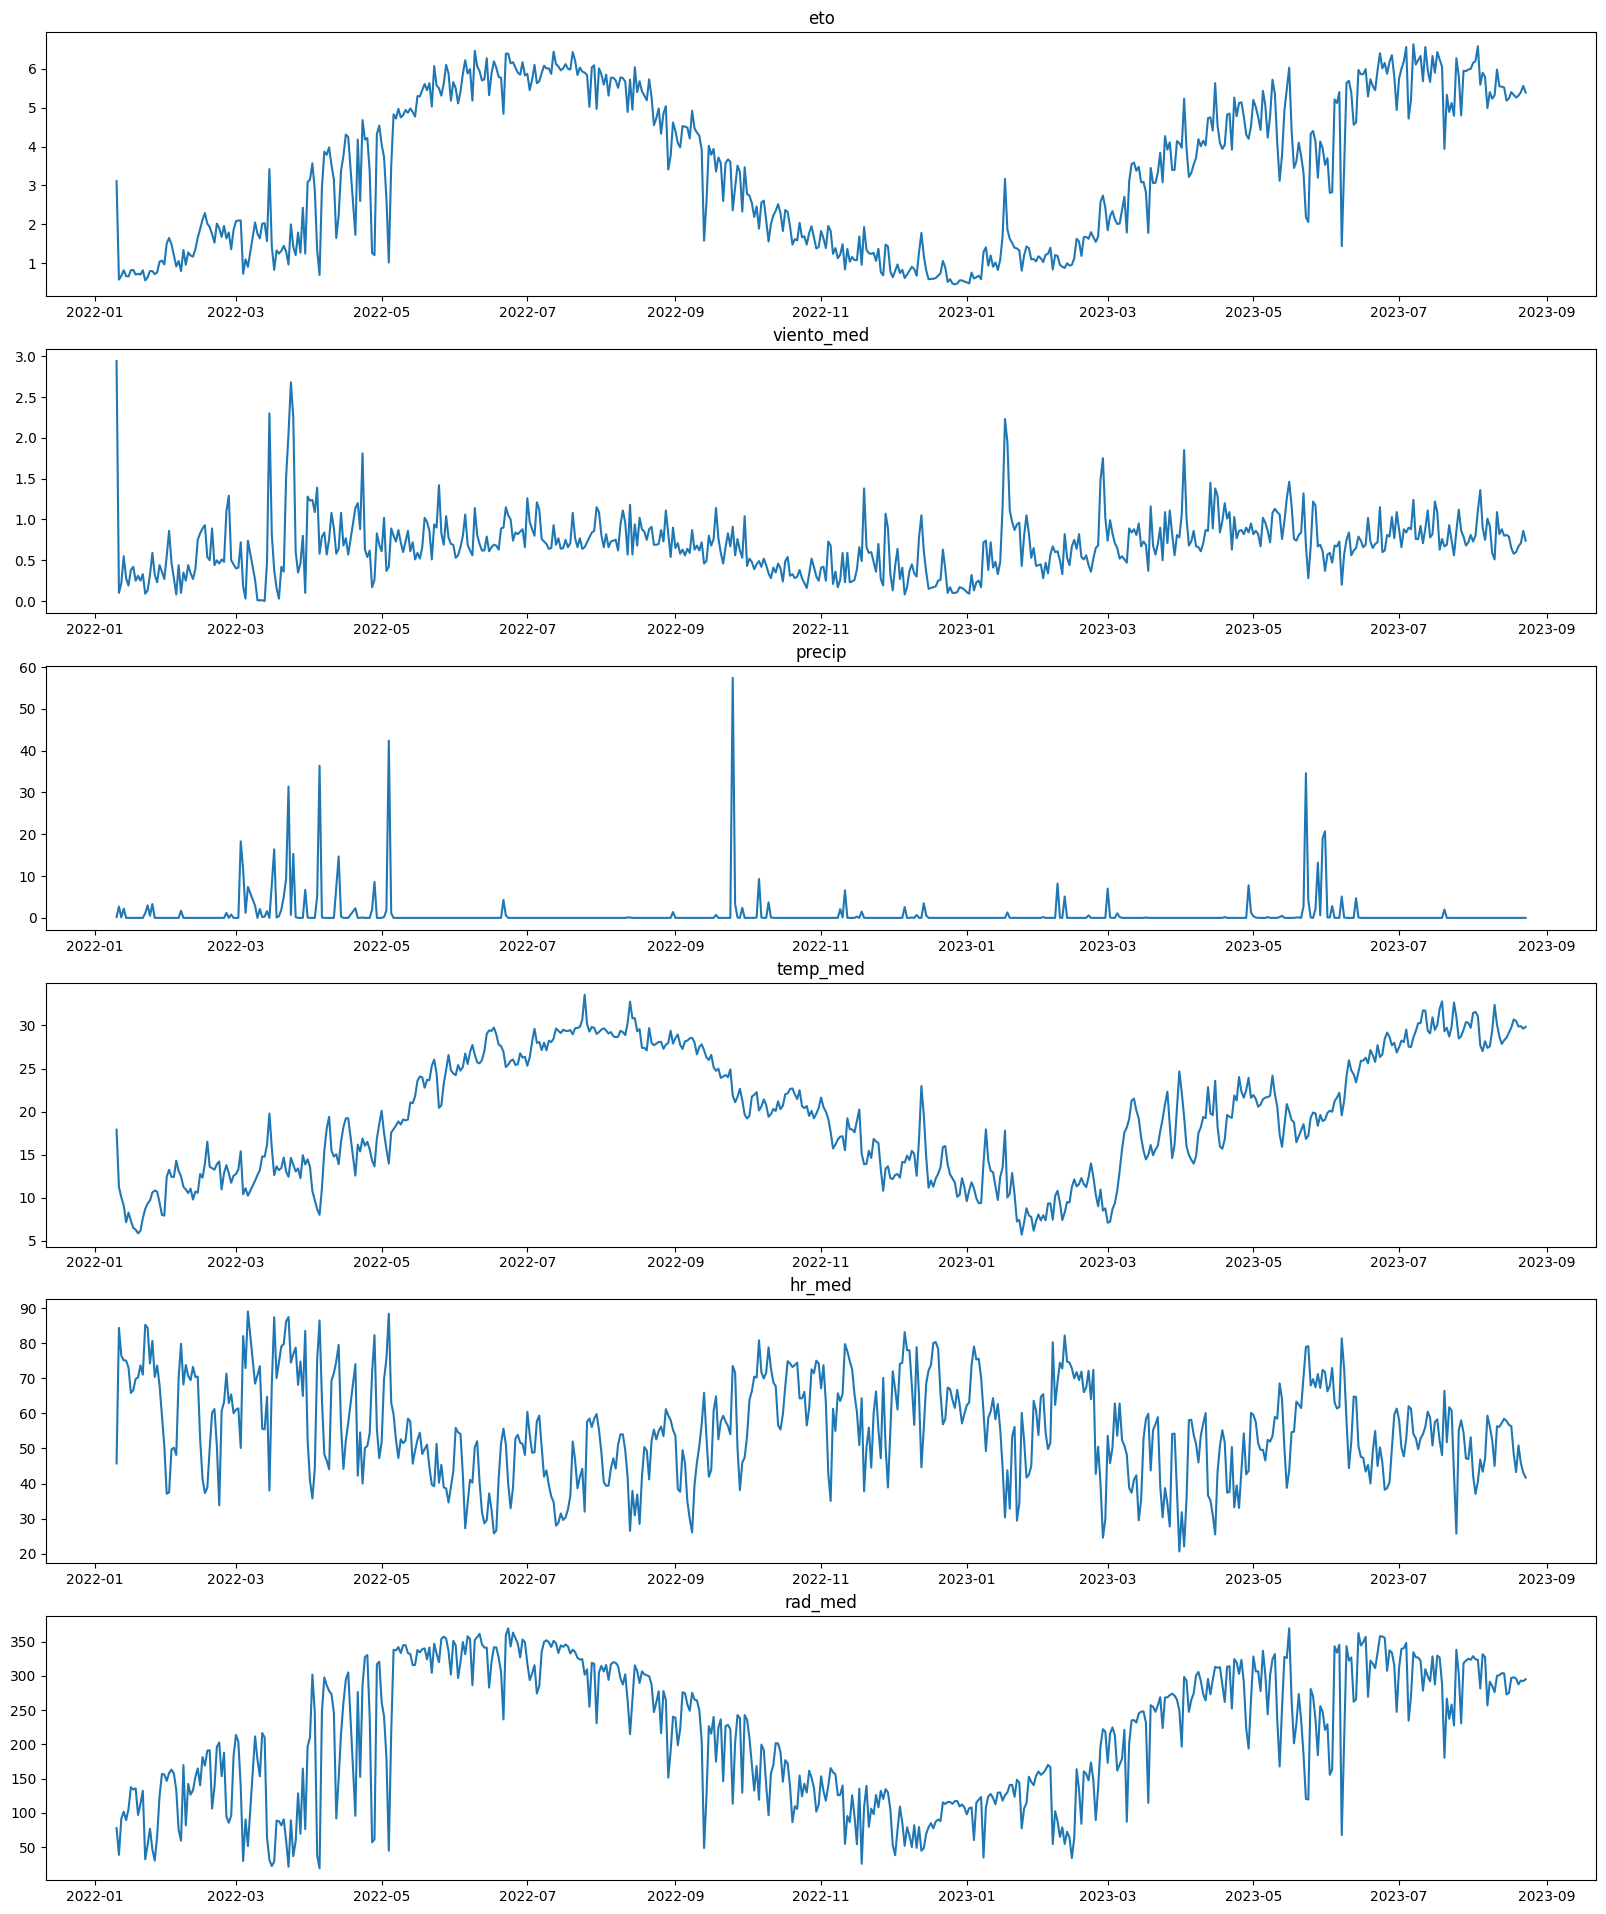

In [11]:
# Plot all variables one after the other in separate line plots, sharing same x-axis
plt.figure(figsize=(20, 24))
for i, col in enumerate(df.columns):
    plt.subplot(6, 1, i+1)
    plt.plot(df.index, df[col])
    plt.title(col)


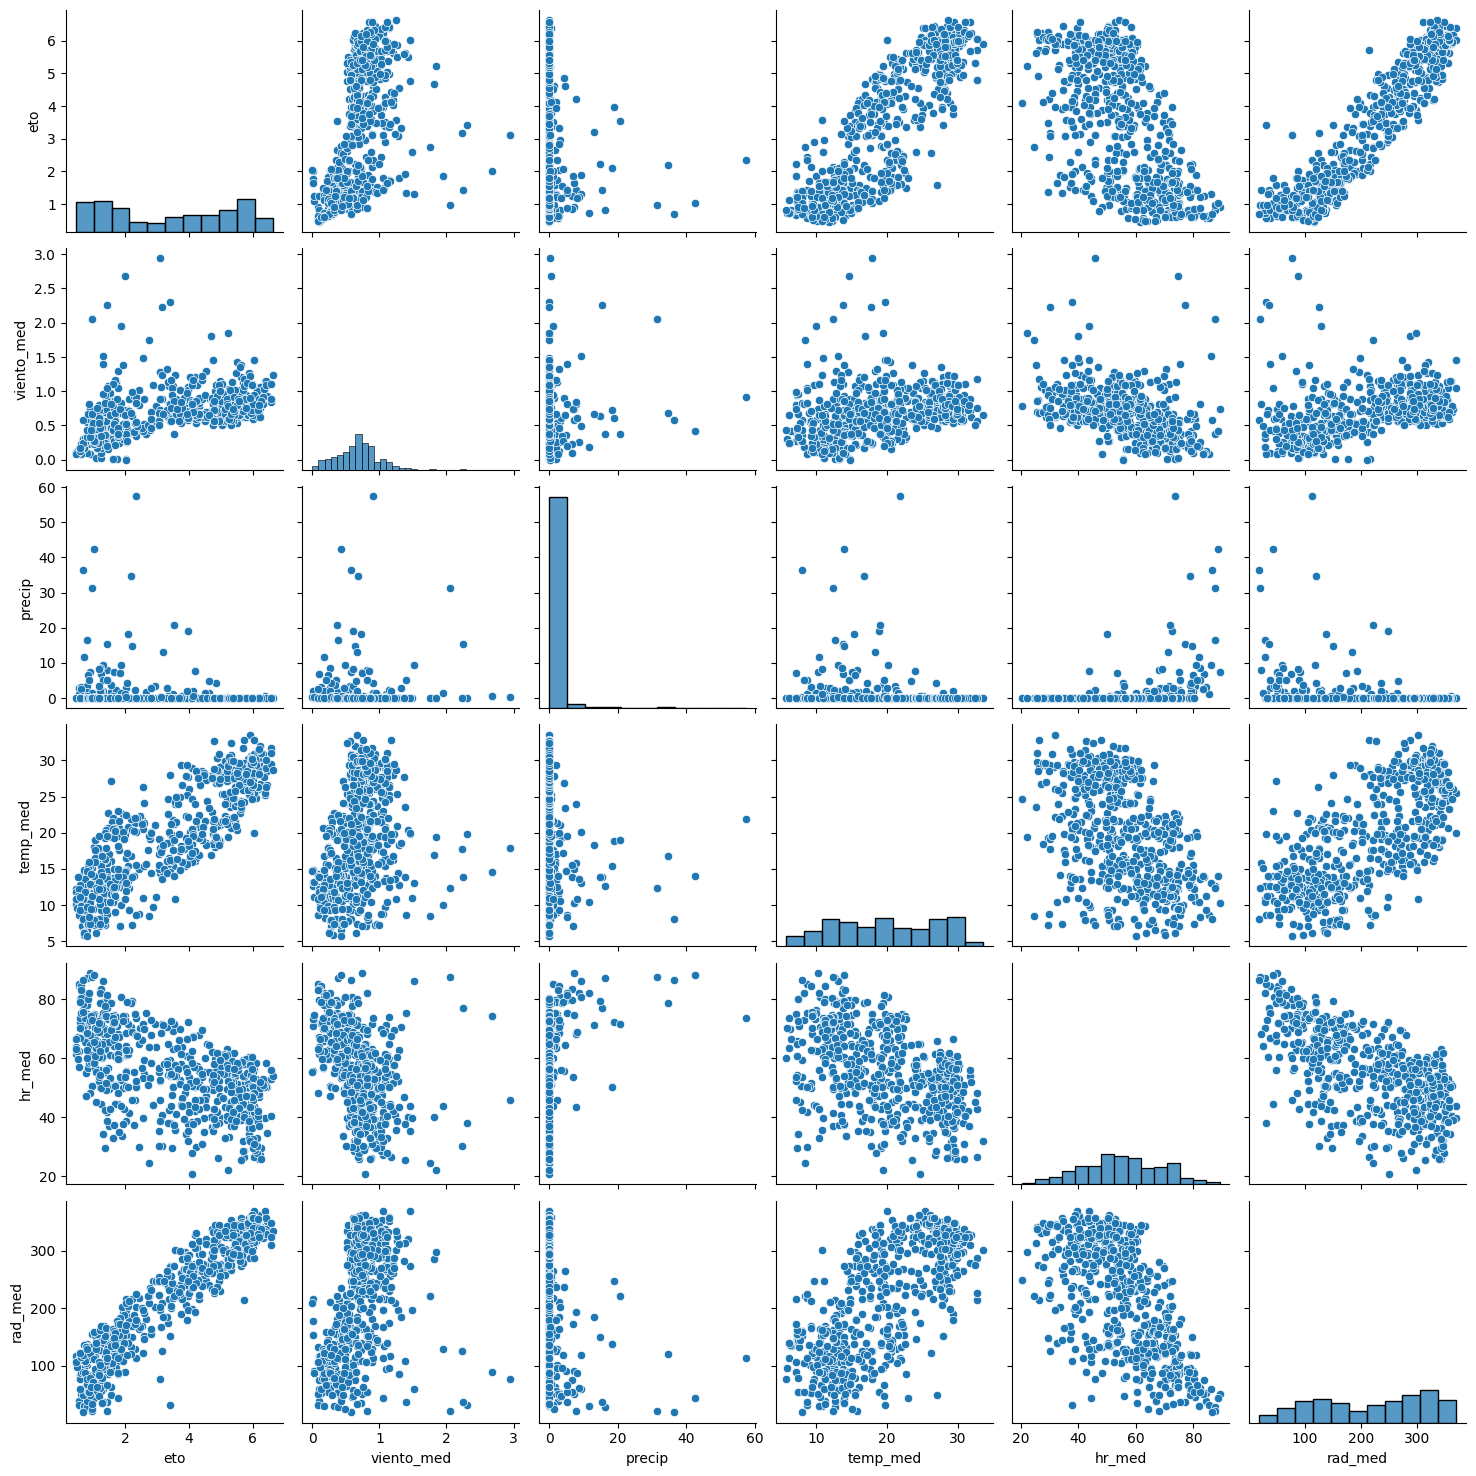

In [12]:
# Plot all variables paired
sns.pairplot(df)

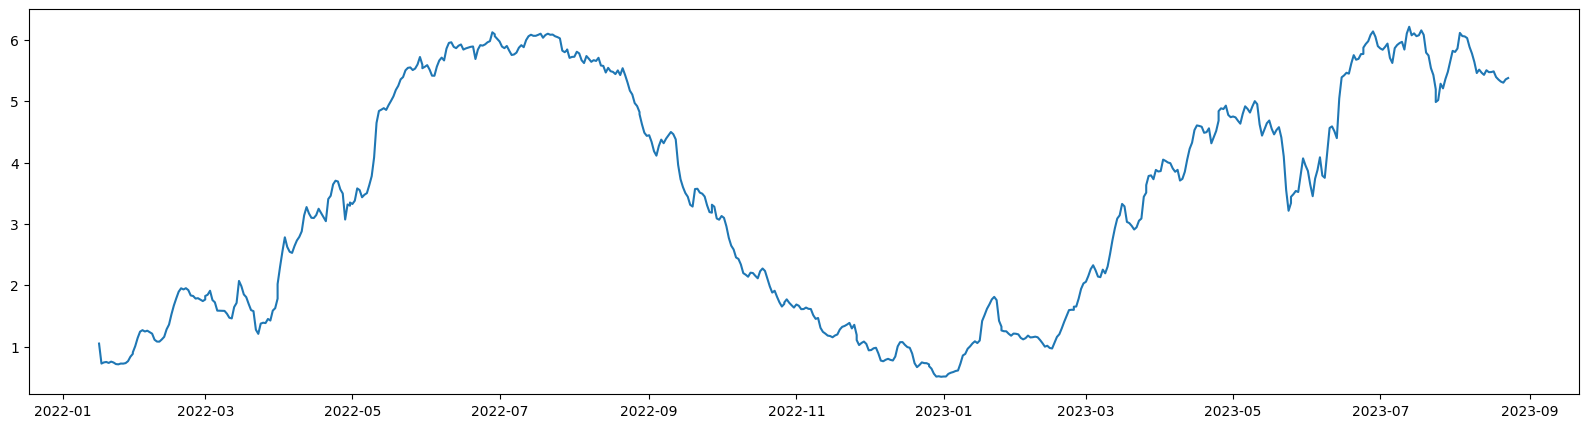

In [13]:
# Obtain trend on eto
df['trend_eto'] = df['eto'].rolling(7).mean()

# Plot the trends
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['trend_eto'])

Residuals mean:  0.0042164473684212144


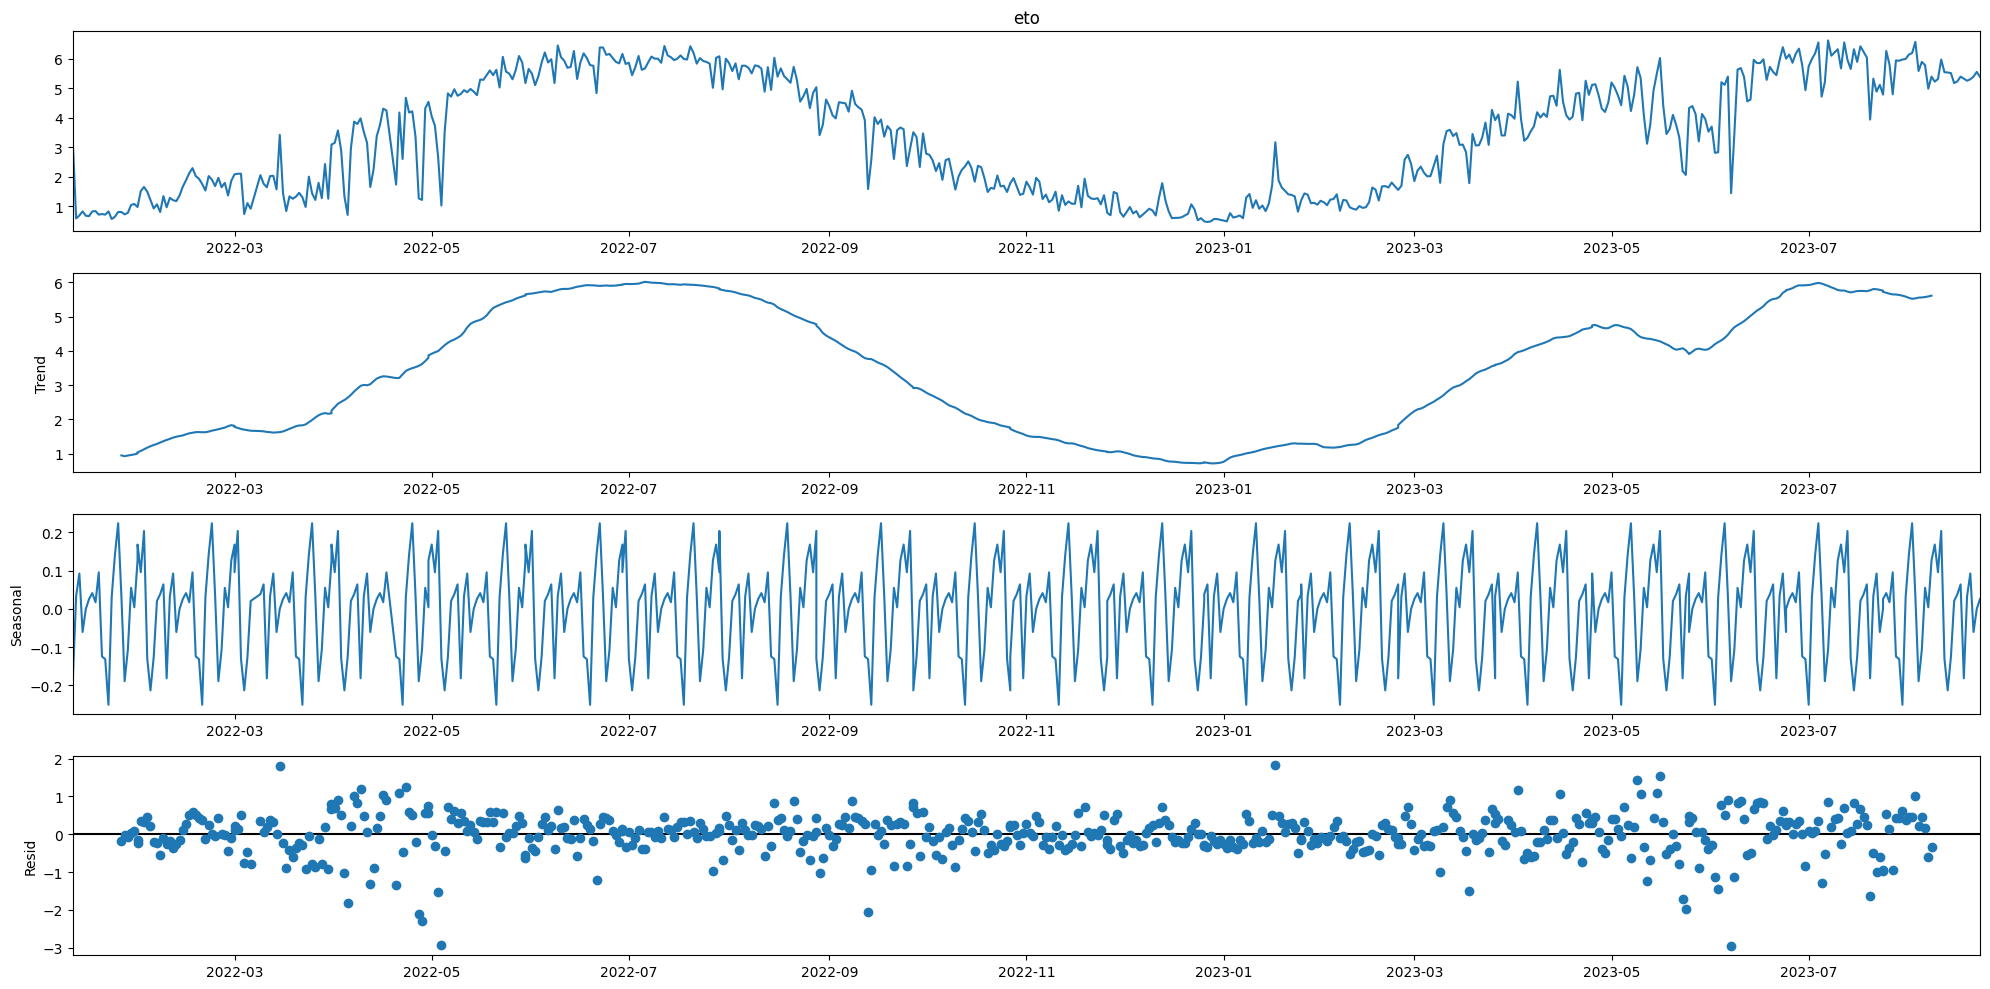

In [14]:
# Seasonal decomposition using moving averages
plt.rc("figure", figsize=(20, 10))
result = seasonal_decompose(df['eto'], model='additive', period=30)
print("Residuals mean: ", result.resid.mean())
sd_plot = result.plot()

In [15]:
# adfuller
result = adfuller(df['eto'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.274695
p-value: 0.640668
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [16]:
# kpss
result = kpss(df['eto'])
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.499051
p-value: 0.041881
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


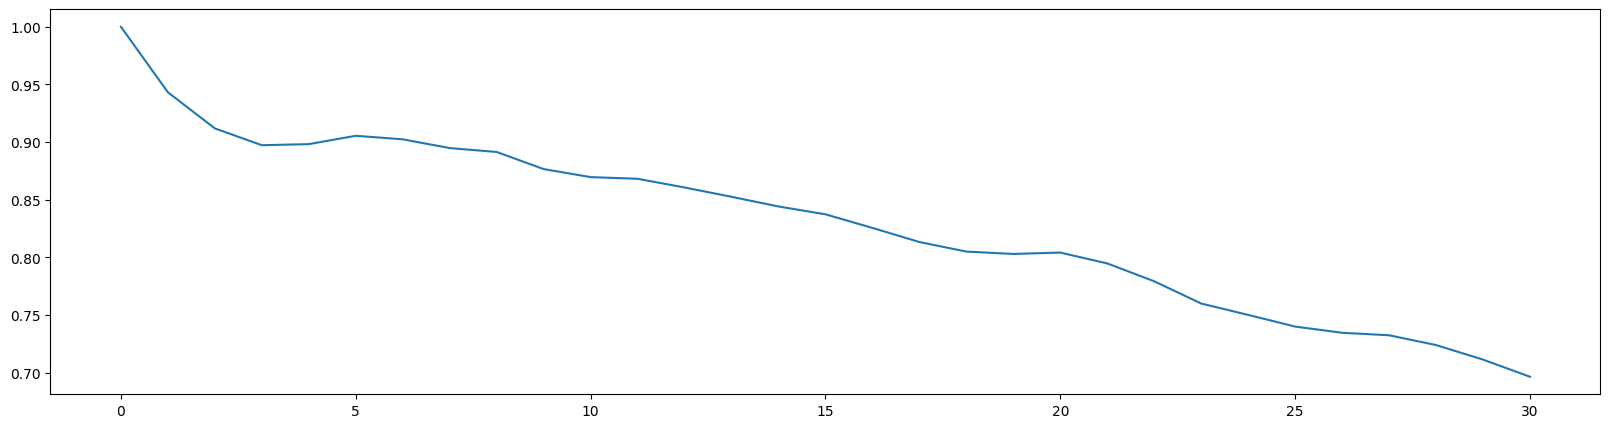

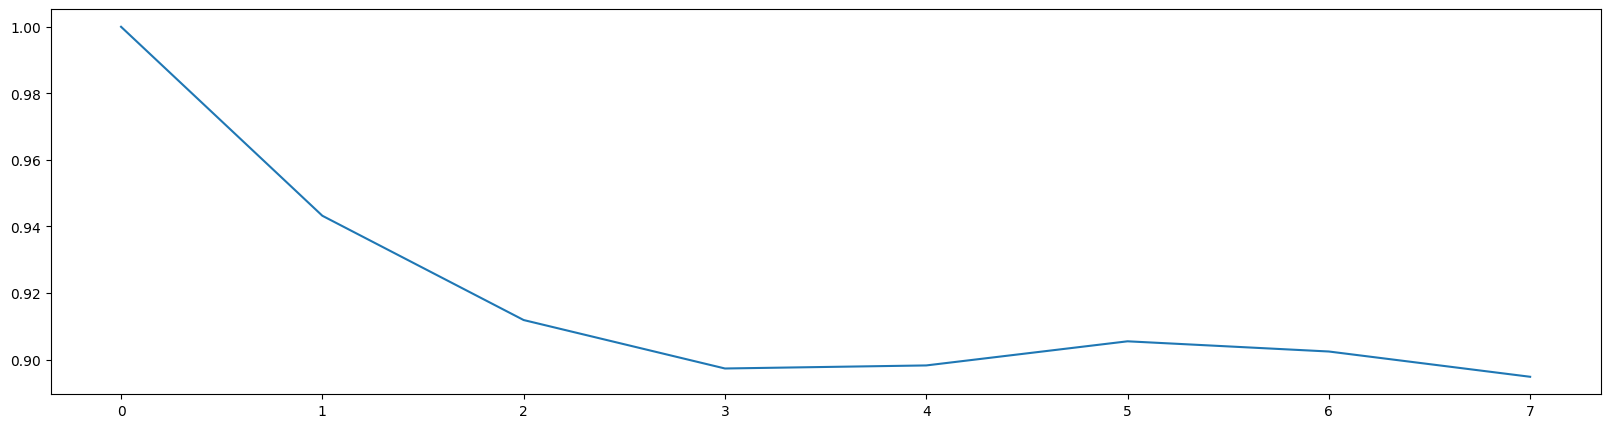

In [17]:
# acf
acf_result = acf(df['eto'], nlags=30)
plt.figure(figsize=(20, 5))
plt.plot(acf_result)

acf_result = acf(df['eto'], nlags=7)
plt.figure(figsize=(20, 5))
plt.plot(acf_result)

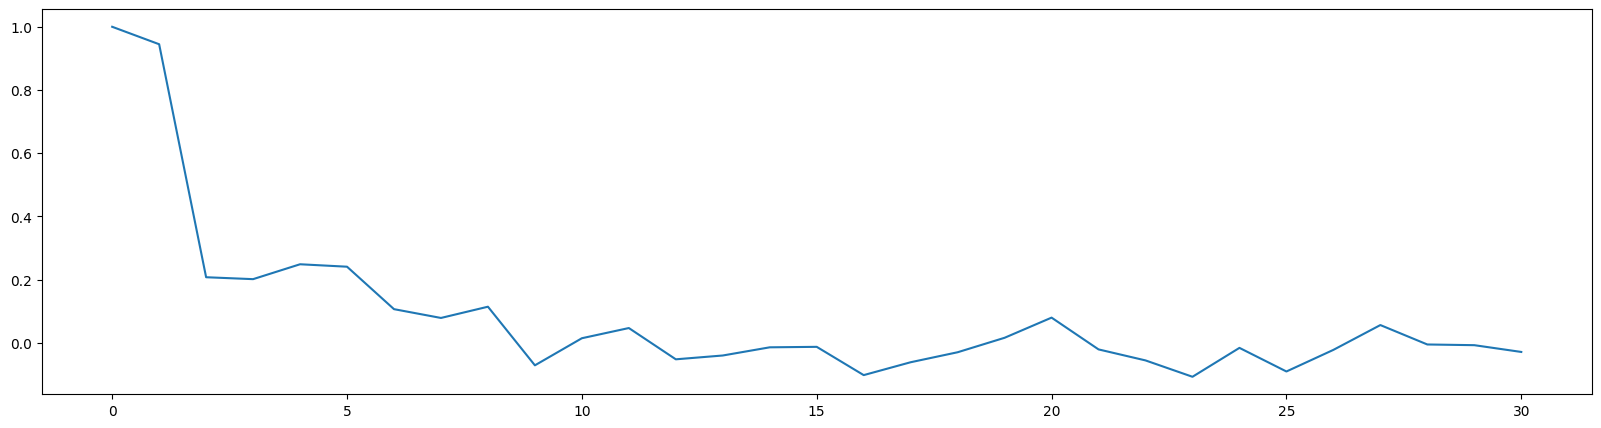

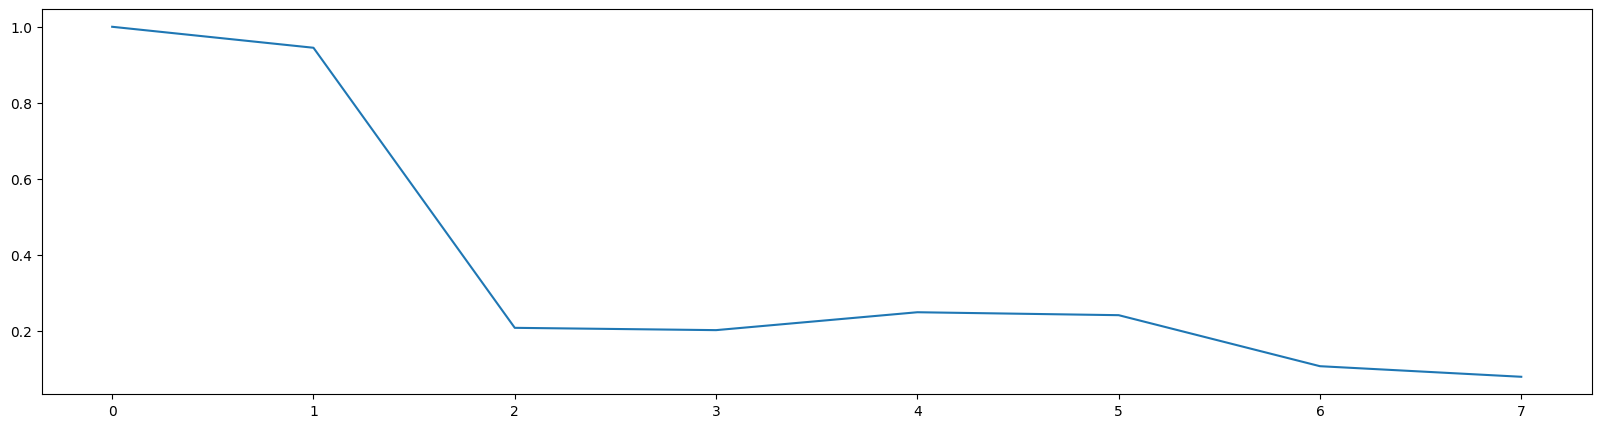

In [18]:
# pacf
pacf_result = pacf(df['eto'], nlags=30)
plt.figure(figsize=(20, 5))
plt.plot(pacf_result)

pacf_result = pacf(df['eto'], nlags=7)
plt.figure(figsize=(20, 5))
plt.plot(pacf_result)

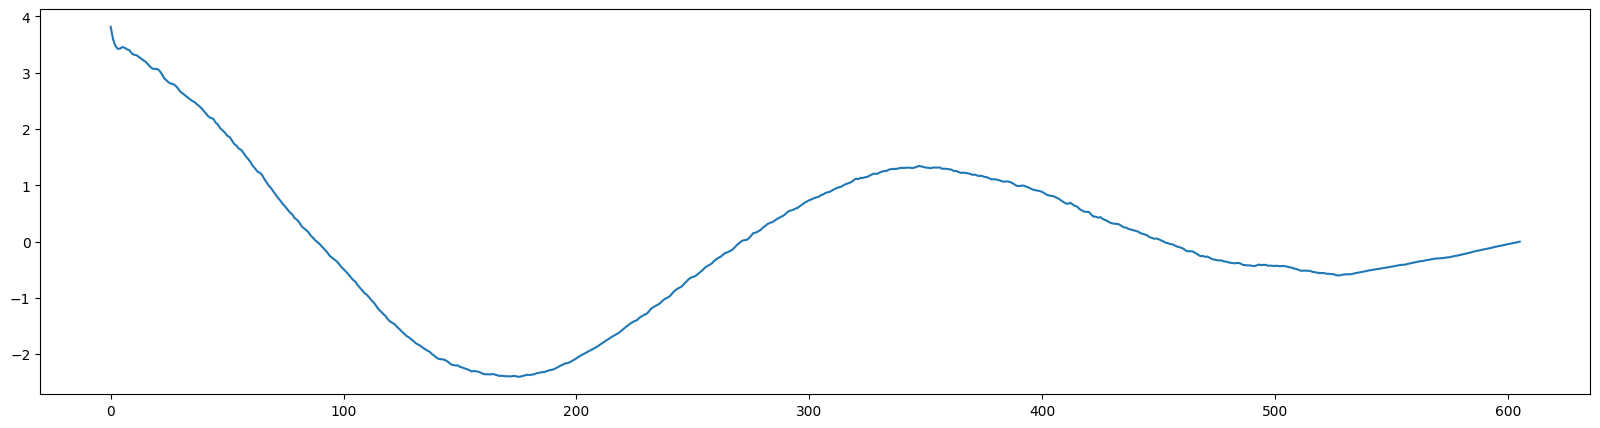

In [19]:
# acovf
plt.figure(figsize=(20, 5))
plt.plot(acovf(df['eto']))

In [20]:
# prepare variables for heatmap
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayName'] = df.index.day_name()
df['weekday'] = df.index.weekday
df['week'] = df.index.isocalendar().week
df['weekend'] = df.index.weekday // 5 == 1

# order weekdays
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df.dayName = pd.Categorical(df.dayName, categories=weekdays, ordered=True)


<Axes: xlabel='day', ylabel='dayName'>

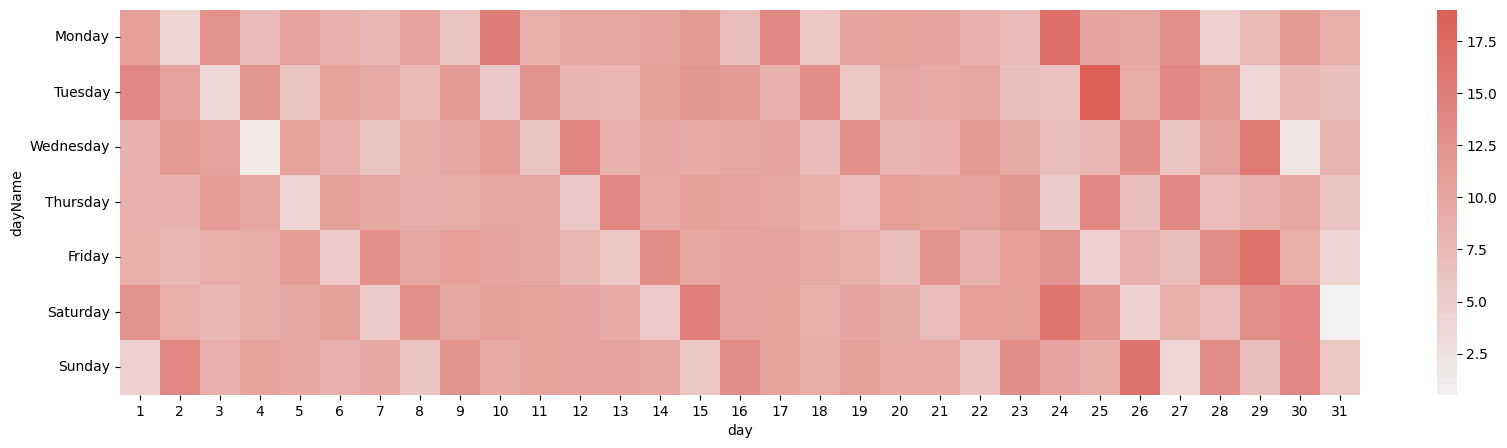

In [21]:
plt.figure(figsize=(20, 5))

# Plot the heatmap
sns.heatmap(pd.pivot_table(df,
              values="eto",
              index=["dayName"],
              columns=["day"],
              aggfunc=np.sum,
              fill_value=0,
            ),
            cmap=sns.light_palette("#db5f57", as_cmap=True)
          )


<Axes: xlabel='day', ylabel='month'>

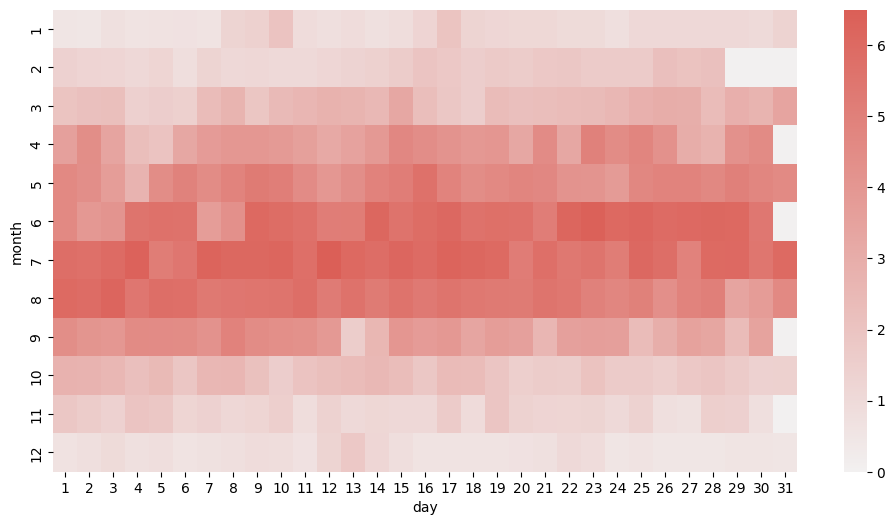

In [22]:
plt.figure(figsize=(12, 6))

# Plot the heatmap
sns.heatmap(pd.pivot_table(df,
              values="eto",
              index=["month"],
              columns=["day"],
              aggfunc=lambda x: x.mean(),
              fill_value=0,
            ), 
            cmap=sns.light_palette("#db5f57", as_cmap=True))